**Loan Default Prediction**

Jing Xu, Brown DSI, 12/11/24

GitHub: https://github.com/Jing-Xu1223/DATA1030-Project

**Binary Classification**

- Highly Imbalanced: nearly 90% in class 0(no loan default), 10% in class 1(cause loan default)

- 16 feature variables(6 categorical, 1 ordinal, 9 continuous), 1 target "default"

- Large dataset(over 250k), No Missing Value, IID Dataset

Dataset is available on Kaggle:Loan Default Prediction, Kaggle: https://www.kaggle.com/datasets/nikhil1e9/loan-default

This dataset is collected by Coursera Project Network:Loan Default Prediction Coding Challenge, which includes a sample of individuals who took financial loans in 2021.
Sources: https://www.coursera.org/projects/data-science-coding-challenge-loan-default-prediction

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, make_scorer, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.inspection import permutation_importance

In [2]:
# Load dataset
df = pd.read_csv('/Users/jingxu/Downloads/DATA1030-Fall2024/DATA1030-Project/data/Loan_default.csv')
df = df.drop(columns=['LoanID'])
print(df.shape)

(255347, 17)


In [4]:
# Split into features (X) and target (y)
y = df['Default'] 
X = df.loc[:, df.columns != 'Default']

**Stratified Kfold Split:** 10% test set, 90% train&validation with 3 folds

**CV pipeline:** see code but will explain in slides

**ML algorithms:** 
- Logistic regression with elastic net
- Random Forest Classification
- SVM(support vector machine) Classification
- XGBoost

**parameters** see param_grids

In [5]:
# Feature groups
ordinal_ftrs = ['Education']
ordinal_cats = [["High School", "Bachelor's", "Master's", "PhD"]]
onehot_ftrs = ['EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
std_ftrs = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

# Preprocessor for features
pre_preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

In [6]:
models = {
    'logistic_elasticnet': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, class_weight='balanced'),
    'random_forest': RandomForestClassifier(class_weight='balanced'),
    'svm': SVC(probability=True, class_weight='balanced'),
    'xgboost': XGBClassifier(eval_metric='logloss', scale_pos_weight=y.value_counts()[0] / y.value_counts()[1])
}

param_grids = {
    'logistic_elasticnet': {
        'C': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    },
    'random_forest': {
        #'n_estimators': [50, 100, 200, 300],
        'max_depth': [1, 3, 5, 10, 20, 30],
        #'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [1, 2, 5],
        'max_features': [0.1, 0.3, 0.5, 0.7, 0.9]
    },
    'svm': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1]
    },
    'xgboost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [1, 3, 5, 7, 10],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

In [7]:
# Use f1 as Evaluation Metric
# Function for Stratified K-Fold cross-validation
def MLpipeline_StratifiedKFold(X, y, preprocessor, ML_algo, param_grid):
    train_scores = []
    test_scores = []
    best_models = []

    for i in range(5):
        random_state = 42*i

        # Split data into other and test sets
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=random_state)

        # Define pipeline with SMOTE
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', ML_algo) ])

        # Update parameter grid with correct step prefix
        param_grid_prefixed = {f'model__{key}': value for key, value in param_grid.items()}

        # K-Fold cross-validation
        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

        # Grid search with cross-validation
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid_prefixed,
            cv=kfold,
            scoring='f1',
            verbose=0,
            n_jobs=-1
        )

        # Fit grid search on the "other" set
        grid_search.fit(X_other, y_other)

        # Save best model parameters
        best_model = grid_search.best_params_
        best_models.append(best_model)

        # Evaluate train and test scores
        train_pred = grid_search.predict(X_other)
        test_pred = grid_search.predict(X_test)

        train_score = f1_score(y_other, train_pred)
        test_score = f1_score(y_test, test_pred)

        train_scores.append(train_score)
        test_scores.append(test_score)

        print(f"Iteration {i + 1}: Train Score = {train_score:.4f}, Test Score = {test_score:.4f}, Best Params = {best_model}")

    # Summary statistics
    print("\nTrain Scores for all iterations:", train_scores)
    print("\nTest Scores for all iterations:", test_scores)
    print(f"\nMean Test Score: {np.mean(test_scores):.4f}")
    print(f"Standard Deviation of Test Scores: {np.std(test_scores):.4f}")
    return train_scores, test_scores, best_models

In [8]:
# Testing the pipeline
results = {}
for model_name, model in models.items():
    print(f"\nTraining model: {model_name}\n{'=' * 60}")

    # Execute pipeline for the current model
    train_scores, test_scores, best_models = MLpipeline_StratifiedKFold(X, y, pre_preprocessor, model, param_grids[model_name])

    results[model_name] = {
        'mean_score': np.mean(test_scores),
        'std_score': np.std(test_scores),
        'best_models': best_models}


Training model: logistic_elasticnet
Iteration 1: Train Score = 0.3332, Test Score = 0.3825, Best Params = {'model__C': 0.1, 'model__l1_ratio': 0.3}
Iteration 2: Train Score = 0.3436, Test Score = 0.3830, Best Params = {'model__C': 0.1, 'model__l1_ratio': 0.7}
Iteration 3: Train Score = 0.3388, Test Score = 0.3510, Best Params = {'model__C': 0.1, 'model__l1_ratio': 0.1}
Iteration 4: Train Score = 0.3429, Test Score = 0.3406, Best Params = {'model__C': 10, 'model__l1_ratio': 0.1}
Iteration 5: Train Score = 0.3460, Test Score = 0.3333, Best Params = {'model__C': 0.1, 'model__l1_ratio': 0.9}

Train Scores for all iterations: [0.33318405732198836, 0.34363636363636363, 0.338768115942029, 0.34285714285714286, 0.34596074851665903]

Test Scores for all iterations: [0.38247011952191234, 0.3829787234042553, 0.3510204081632653, 0.3406113537117904, 0.3333333333333333]

Mean Test Score: 0.3581
Standard Deviation of Test Scores: 0.0209

Training model: random_forest
Iteration 1: Train Score = 0.4691

In [9]:
# Summary of results
print(f"\n{'=' * 60}\nSummary of Findings\n{'=' * 60}")
for model_name, result in results.items():
    print(f"{model_name}: Mean f1_score = {result['mean_score']:.4f}, Std f1_score = {result['std_score']:.4f}")


Summary of Findings
logistic_elasticnet: Mean f1_score = 0.3581, Std f1_score = 0.0209
random_forest: Mean f1_score = 0.3312, Std f1_score = 0.0260
svm: Mean f1_score = 0.3633, Std f1_score = 0.0226
xgboost: Mean f1_score = 0.3529, Std f1_score = 0.0421


In [10]:
# Find the best model based on mean accuracy
best_model_name = max(results, key=lambda model: results[model]['mean_score'])
best_model = results[best_model_name]['best_models'][0]  # Use the first iteration's best model
print(f"\nBest Model: {best_model_name}")


Best Model: svm


In [11]:
# Assuming `y` contains the true labels and `y_pred` contains the baseline predictions
# Baseline 1: Predict all zeros (no positive predictions)
y_pred_all_zero = np.zeros_like(y)
# Baseline 2: Predict all ones (all positive predictions)
y_pred_all_one = np.ones_like(y)

# Calculate F1-score for class 1 baselines
baseline = f1_score(y, y_pred_all_one, average='binary')
print(f"\nBaseline F1 Score (class 1): {baseline:.4f}")


Baseline F1 Score (class 1): 0.2081


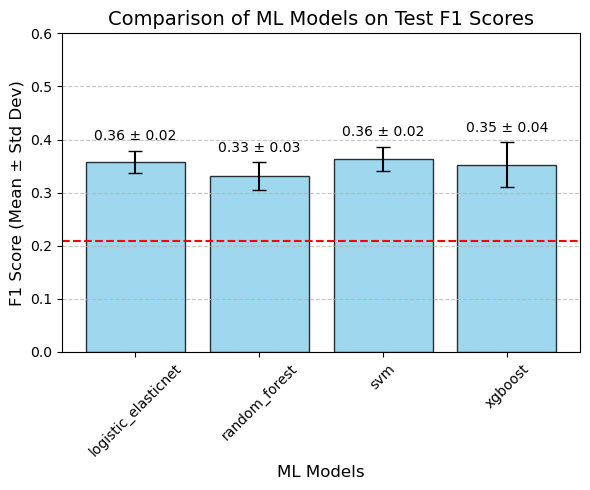

In [45]:
# Assuming `results` contains the mean and std scores for each model
model_names = list(results.keys())
mean_scores = [results[model]['mean_score'] for model in model_names]
std_scores = [results[model]['std_score'] for model in model_names]

plt.figure(figsize=(6, 5))
# Plot mean scores with error bars representing standard deviation
plt.bar(model_names, mean_scores, yerr=std_scores, capsize=5, color='skyblue', alpha=0.8, edgecolor='black')
# Add the baseline as a horizontal line
plt.axhline(y=baseline, color='red', linestyle='--', linewidth=1.5, label=f'Baseline ({baseline})')

# Add labels, title, and grid
plt.xlabel('ML Models', fontsize=12)
plt.ylabel('F1 Score (Mean ± Std Dev)', fontsize=12)
plt.title('Comparison of ML Models on Test F1 Scores', fontsize=14)
plt.ylim(0, 0.6)  # F1 scores range from 0 to 1
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the mean scores on the bars
for i, (mean, std) in enumerate(zip(mean_scores, std_scores)):
    plt.text(i, mean + std + 0.02, f'{mean:.2f} ± {std:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Best Model: svm
Best Hyperparameter: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}


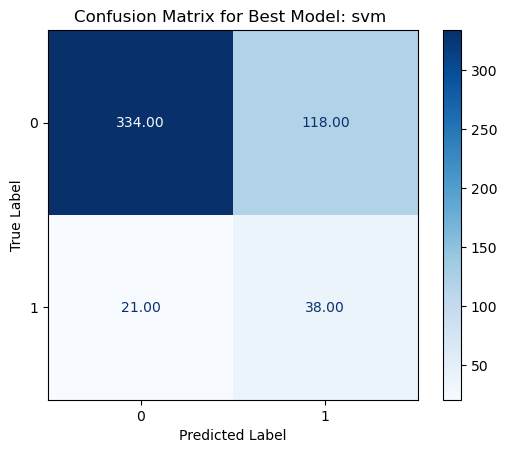

In [16]:
# Assuming the best model and its parameters have been determined
best_model_pipeline = Pipeline([
    ('preprocessor', pre_preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', models[best_model_name])])

# Retrieve the best hyperparameters and set them to the model
best_hyperparams = {key.replace('model__', ''): value for key, value in best_model.items()}
best_model_pipeline.named_steps['model'].set_params(**best_hyperparams)
print(f"Best Model: {best_model_name}")
print(f"Best Hyperparameter: {best_hyperparams}")

# Final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
best_model_pipeline.fit(X_train, y_train)
y_pred = best_model_pipeline.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_pipeline.named_steps['model'].classes_)
disp.plot(cmap='Blues', values_format=".2f")  # Format as percentage with two decimal places
plt.title(f"Confusion Matrix for Best Model: {best_model_name} ")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Global 1:permutation feature importance**

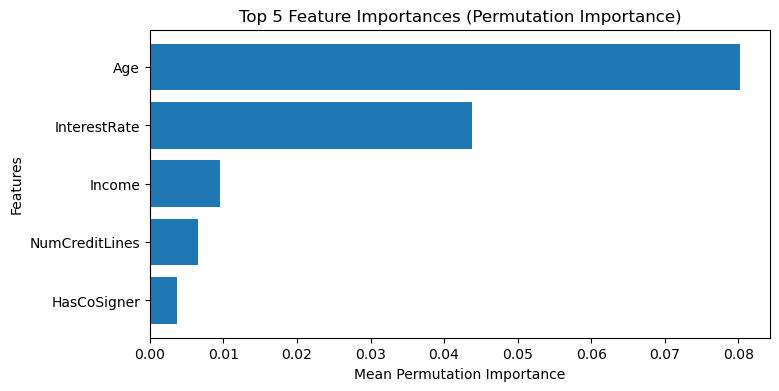

In [19]:
# Calculate permutation feature importance on the test set
result = permutation_importance(
    best_model_pipeline,
    X_test,
    y_test,
    scoring='f1',
    n_repeats=30,
    random_state=42,
    n_jobs=-1)

# Extract feature importance
importances = result.importances_mean
std_importances = result.importances_std
features = X_test.columns

# Create a DataFrame for sorting and visualization
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances,
    "Std": std_importances}).sort_values(by="Importance", ascending=False)

# Select top 5 features
top_5_features = importance_df.head(5)

# Visualize the top 5 features
plt.figure(figsize=(8, 4))
plt.barh(top_5_features["Feature"], top_5_features["Importance"], align="center")
plt.xlabel("Mean Permutation Importance")
plt.ylabel("Features")
plt.title("Top 5 Feature Importances (Permutation Importance)")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

**Global 2: Weights of the support vectors**

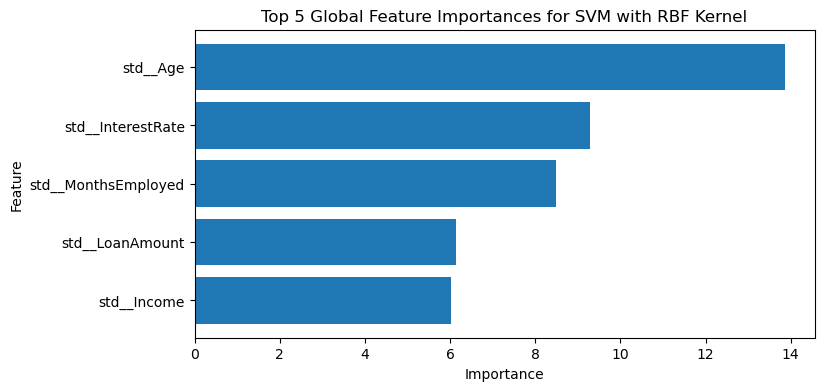

In [24]:
# Train the final SVM model with the best parameters
best_model = SVC(C=0.01, gamma='scale', kernel='rbf', probability=True, class_weight='balanced')
pipeline = Pipeline([
    ('preprocessor', pre_preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', best_model)])

# Fit the pipeline on the entire dataset
pipeline.fit(X_train, y_train)

# Extract the support vectors and their weights
sv_indices = pipeline.named_steps['model'].support_
sv_weights = pipeline.named_steps['model'].dual_coef_

# Project support vectors back to feature space using the RBF kernel
support_vectors = pipeline.named_steps['model'].support_vectors_
kernel_weights = np.dot(support_vectors.T, sv_weights.T)

# Compute feature importances as the norm of the weights
feature_importances = np.linalg.norm(kernel_weights, axis=1)

# Map feature importances to feature names
feature_names = (
    pipeline.named_steps['preprocessor']
    .get_feature_names_out(input_features=X.columns)
)
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_5_features = feature_importances_df.head(5)

# Plot the top 10 feature importances
plt.figure(figsize=(8, 4))
plt.barh(top_5_features['Feature'], top_5_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 5 Global Feature Importances for SVM with RBF Kernel')
plt.gca().invert_yaxis()
plt.show()

**Global 3: SHAP Global Importance**

  0%|          | 0/51 [00:00<?, ?it/s]

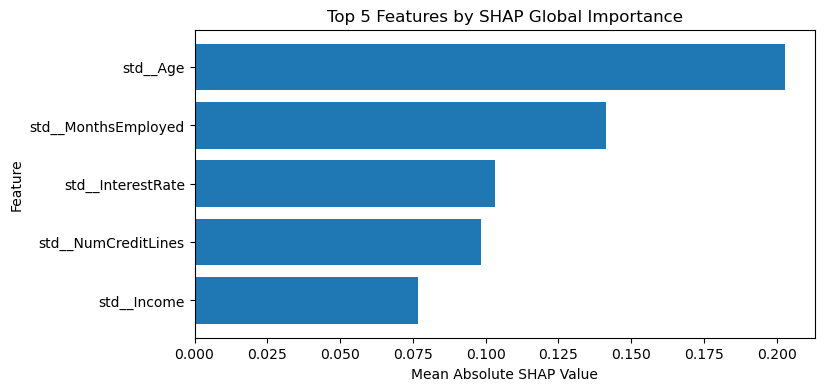

In [31]:
import shap
# Ensure data is transformed using the same preprocessing pipeline
X_sample = X_test.sample(frac=0.1, random_state=42)
X_transformed_sample = best_model_pipeline.named_steps['preprocessor'].transform(X_sample)

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(
    best_model_pipeline.named_steps['model'].predict, 
    X_transformed_sample
)

# Compute SHAP values
shap_values = explainer.shap_values(X_transformed_sample)

# Aggregate SHAP values to calculate global feature importance
shap_importances = np.abs(shap_values).mean(axis=0)

# Extract transformed feature names
transformed_feature_names = best_model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for visualization
shap_importance_df = pd.DataFrame({
    "Feature": transformed_feature_names,
    "Importance": shap_importances
}).sort_values(by="Importance", ascending=False).head(5)

# Plot SHAP global feature importance
plt.figure(figsize=(8, 4))
plt.barh(shap_importance_df["Feature"], shap_importance_df["Importance"], align="center")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("Top 5 Features by SHAP Global Importance")
plt.gca().invert_yaxis()
plt.show()

**Local: SHAP Local Importance**

  0%|          | 0/3 [00:00<?, ?it/s]

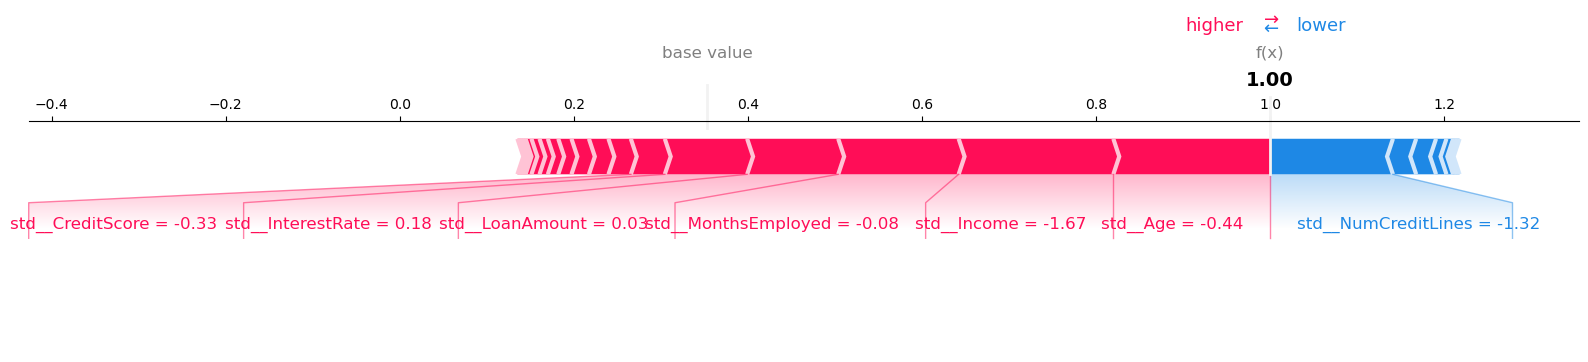

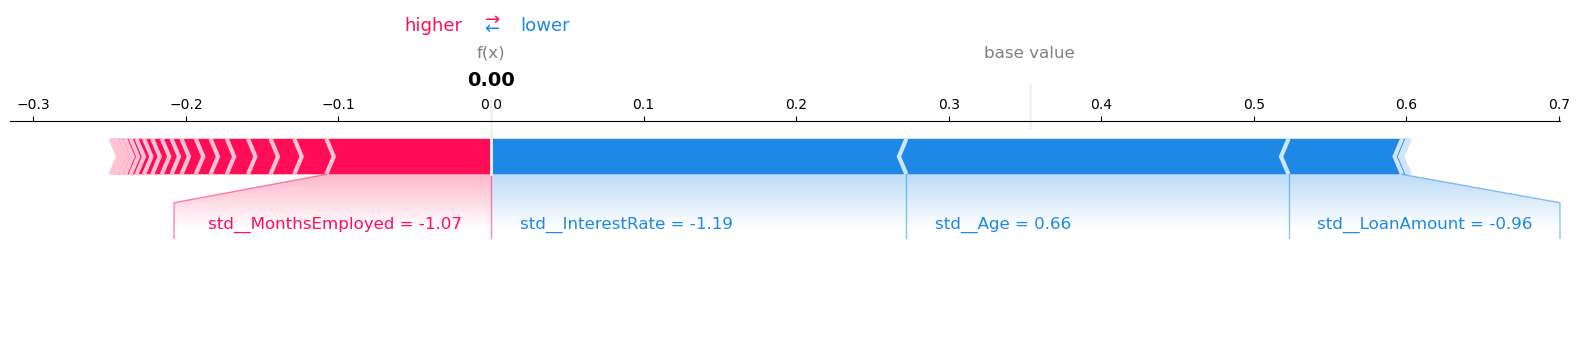

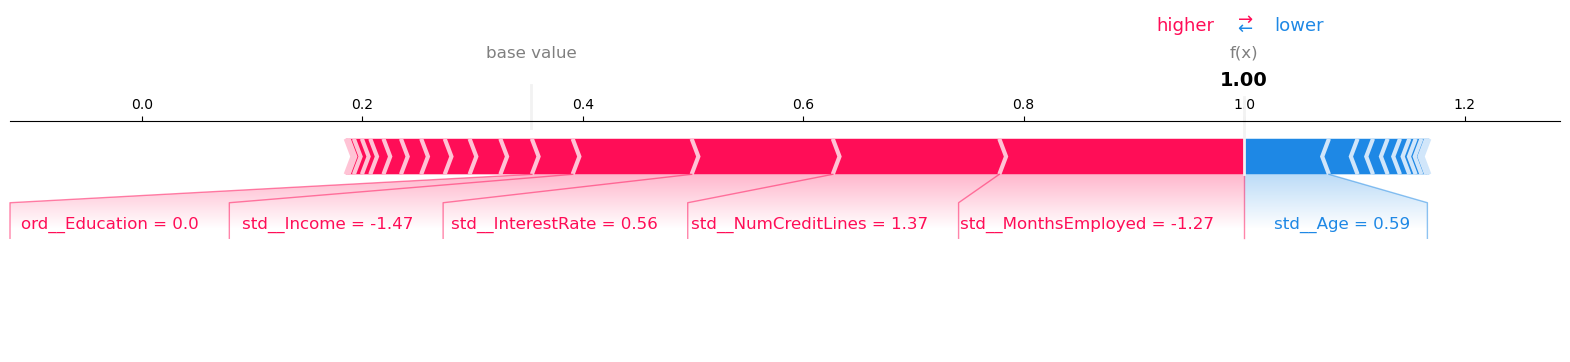

In [36]:
# Select a few instances to visualize local explanations
X_local_sample = X_test.sample(n=3, random_state=42)  # Choose 3 instances
X_transformed_local = best_model_pipeline.named_steps['preprocessor'].transform(X_local_sample)

# Compute SHAP values for the selected instances
shap_values_local = explainer.shap_values(X_transformed_local)

# Round transformed feature values to 2 decimals
X_transformed_local_rounded = np.round(X_transformed_local, 2)

# Plot SHAP local explanations for each selected instance
for i, instance_index in enumerate(X_local_sample.index):
    shap.force_plot(
        explainer.expected_value,  # Base value of the model's output
        shap_values_local[i],      # SHAP values for the instance
        X_transformed_local_rounded[i],  # Rounded transformed feature values
        feature_names=transformed_feature_names,
        matplotlib=True
    )